# Simulation and statistical analysis

In [1]:
from __future__ import annotations
import numpy as np
from math import gamma, sqrt, erfc, exp, pi
from dataclasses import dataclass
from typing import Optional, Callable
import matplotlib.pyplot as plt

## Distribution models and data generation

In [2]:
@dataclass
class BinnedBinaryDataset:
  n: int
  pb: float
  s: float
  w: float
  g: np.ndarray   # shape (n,) Gaussian shape (max=1)
  p: np.ndarray   # shape (n,) 成功確率
  x: np.ndarray   # shape (n,) 観測データ (0/1)
  clipped: bool

In [3]:
def _gaussian_shape(n: int, w: float, center: Optional[float] = None) -> np.ndarray:
  if w <= 0:
    raise ValueError("w must be positive.")
  mu = (n - 1) / 2.0 if center is None else float(center)
  i = np.arange(n, dtype=float)
  u = (i - mu) / w
  g = np.exp(-0.5 * u ** 2)
  dg_dmu = g * (u / w)               # ∂g/∂μ
  dg_dw  = g * ((i - mu)**2 / w**3)  # ∂g/∂w
  return g, dg_dmu, dg_dw

In [4]:
def generate_binned_binary_dataset(
  n: int,
  pb: float,
  s: float,
  w: float,
  seed: Optional[int] = None
) -> BinnedBinaryDataset:
  if not (0.0 <= pb <= 1.0):
    raise ValueError("pb must be in [0,1].")
  if s < 0.0:
    raise ValueError("s must be non-negative.")

  rng = np.random.default_rng(seed)
  g, *_ = _gaussian_shape(n, w)
  p_raw = pb + s * g
  p = np.clip(p_raw, 0.0, 1.0)
  clipped = bool(np.any(p != p_raw))
  x = rng.binomial(1, p, size=n).astype(int)
  return BinnedBinaryDataset(n=n, pb=pb, s=s, w=w, g=g, p=p, x=x, clipped=clipped)

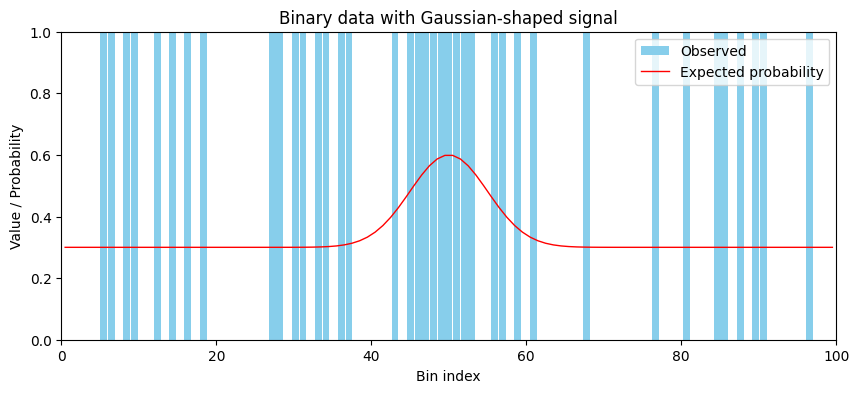

In [5]:
# データ生成
data = generate_binned_binary_dataset(n=100, pb=0.3, s=0.3, w=5.0, seed=123)

fig, ax = plt.subplots(figsize=(10, 4))

# 観測 (0/1 並び) をヒスト風に表示
ax.hist(np.arange(data.n), bins=data.n, weights=data.x,
        rwidth=0.9, color="skyblue", label="Observed")

# 期待確率
ax.plot(np.arange(data.n)+0.5, data.p, lw=1.0,
       color="red", label="Expected probability")

# 軸範囲を固定
ax.set_xlim(0, data.n)
ax.set_ylim(0, 1)

ax.set_xlabel("Bin index")
ax.set_ylabel("Value / Probability")
ax.set_title("Binary data with Gaussian-shaped signal")
ax.legend()
plt.show()


## Statistical analysis

In [6]:
# ---- 対数尤度・勾配・対角ヘッセ近似 ----
def ll_grad_hessdiag(x: np.ndarray, pb: float, s: float, mu: float, w: float, eps: float = 1e-12):
  n = x.size
  g, dg_mu, dg_w = _gaussian_shape(n, w, center=mu)
  p = np.clip(pb + s * g, eps, 1 - eps)
  ll = float(np.sum(x * np.log(p) + (1 - x) * np.log(1 - p)))

  # r = (x - p) / (p(1-p)),  weight = x/p^2 + (1-x)/(1-p)^2
  r = (x - p) / (p * (1 - p))
  weight = x / (p**2) + (1 - x) / ((1 - p)**2)

  grad_s   = float(np.sum(g * r))
  grad_mu  = float(np.sum((s * dg_mu) * r))
  grad_w   = float(np.sum((s * dg_w)  * r))

  # 対角ヘッセ近似（負値）：交差項は無視
  hss   = -float(np.sum((g       **2) * weight))
  hmm   = -float(np.sum(((s*dg_mu)**2) * weight))
  hww   = -float(np.sum(((s*dg_w )**2) * weight))

  return ll, (grad_s, grad_mu, grad_w), (hss, hmm, hww), (g, dg_mu, dg_w), p

In [7]:
# ---- 投影関数 ----
def _proj(val, lo, hi):
  return lo if val < lo else (hi if val > hi else val)

In [8]:
# ---- 多変量（s, μ, w）最尤化：free に含めた成分だけ更新 ----
def maximize_ll(
  x: np.ndarray,
  pb: float,
  n: int,
  s0: float,
  mu0: float,
  w0: float,
  free=("s",),                  # ("s",) または ("s","mu","w")
  one_sided: bool = False,       # 片側（s>=0）かどうか
  w_bounds=(1e-2, None),        # w の下限と上限（上限 None なら n で代用）
  tol: float = 1e-7,
  max_iter: int = 200
):
  s_lo, s_hi = (0.0, 1.0 - pb) if one_sided else (-pb, 1.0 - pb)
  mu_lo, mu_hi = 0.0, float(n - 1)
  w_lo, w_hi = w_bounds[0], (w_bounds[1] if w_bounds[1] is not None else float(n))

  s = _proj(float(s0), s_lo, s_hi)
  mu = _proj(float(mu0), mu_lo, mu_hi)
  w = _proj(float(max(w0, w_lo)), w_lo, w_hi)

  # 端点での単調性チェック（s のみ）。μ,w はH0では識別不能だがH1では自由。
  # ただしここでは数値安定のため通常更新へ。
  ll_prev = -np.inf

  for _ in range(max_iter):
    ll, (gs, gmu, gw), (hss, hmm, hww), _, _ = ll_grad_hessdiag(x, pb, s, mu, w)

    # 収束判定（尤度増分とパラメータ更新がともに小さい）
    if abs(ll - ll_prev) < 1e-10:
      break
    ll_prev = ll

    # 対角ニュートンステップ（最大化なので -grad/hess）
    ds  = 0.0 if "s"  not in free or hss == 0.0 else -gs  / hss
    dmu = 0.0 if "mu" not in free or hmm == 0.0 else -gmu / hmm
    dw  = 0.0 if "w"  not in free or hww == 0.0 else -gw  / hww

    # ステップ制限（暴走抑制）
    # s は確率スケール、μ はビン単位、w は正値なので相対的に小さめに
    ds  = np.clip(ds,  -0.5*(s_hi - s_lo),  0.5*(s_hi - s_lo))
    dmu = np.clip(dmu, -0.5*n,             0.5*n)
    dw  = np.clip(dw,  -0.5*w,             0.5*w)

    # バックトラック（Armijo）
    alpha = 1.0
    c = 1e-4
    improved = False
    base_ll = ll

    for _bt in range(50):
      s_new  = _proj(s  + alpha * ds,  s_lo,  s_hi)
      mu_new = _proj(mu + alpha * dmu, mu_lo, mu_hi)
      w_new  = _proj(w  + alpha * dw,  w_lo,  w_hi)
      ll_new, *_rest = ll_grad_hessdiag(x, pb, s_new, mu_new, w_new)
      # 方向微分の近似：diag なので <grad, step> を素朴に
      dot_dir = gs*(s_new - s) + gmu*(mu_new - mu) + gw*(w_new - w)
      if ll_new >= base_ll + c * dot_dir:
        s, mu, w = s_new, mu_new, w_new
        improved = True
        break
      alpha *= 0.5

    if not improved:
      # 進めない場合は終了（局所最適 or 境界）
      break

    # パラメータ変化が十分小さいなら終了
    if abs(ds*alpha) < tol and abs(dmu*alpha) < tol and abs(dw*alpha) < tol:
      break

  # 最終値と最終尤度
  ll, *_ = ll_grad_hessdiag(x, pb, s, mu, w)
  return s, mu, w, ll

In [9]:
# ---- LRT 本体：自由度1（sのみ）か、自由度3（s,mu,w）かを選ぶ ----
@dataclass
class LRTResult:
  mode: str          # "df1" or "df3"
  s_hat: float
  mu_hat: float | None
  w_hat: float | None
  ll0: float
  llhat: float
  T: float
  p_chi: float | None           # Wilks 近似に基づく片側/両側 p（df=1 or 3）
  p_chernoff: float | None      # 片側(df=1)の混合分布（1/2 δ0 + 1/2 χ1^2）p

In [10]:
def _ll_at_s0(x: np.ndarray, pb: float, eps: float = 1e-12) -> float:
  p0 = np.clip(pb, eps, 1 - eps)
  return float(np.sum(x * np.log(p0) + (1 - x) * np.log(1 - p0)))

In [11]:
def chi2_sf_df1(t: float) -> float:
  # P[χ1^2 >= t] = erfc(√(t/2))
  return erfc(sqrt(max(t, 0.0) / 2.0))

In [12]:
def chi2_sf_df3(t: float) -> float:
  # 半整数形状の閉形式：Q(3/2, x)=erfc(√x)+(2/√π)√x e^{-x}, x=t/2
  x = max(t, 0.0) / 2.0
  return erfc(sqrt(x)) + (2.0 / sqrt(pi)) * sqrt(x) * exp(-x)

In [27]:
def lrt(
  x: np.ndarray,
  pb: float,
  n: int,
  mode: str = "df1",           # "df1": sのみ, "df3": s,mu,w
  one_sided: bool = False,     # 片側 LRT（s>=0）。df3で厳密な漸近は非自明→pはWilks近似
  init: dict | None = None,    # 初期値例: {"s":0.1,"mu":(n-1)/2,"w":5.0}
  w_bounds=(1e-2, None)
) -> LRTResult:
  if mode not in ("df1", "df3"):
    raise ValueError("mode must be 'df1' or 'df3'.")

  # 初期値
  if mode == "df1" and not init:
    print("Specify the signal shape (init) for the mode 'df1'")
    return
  else:
    s0 = 0.1
    mu0 = (init.get("mu") if init else (n - 1) / 2.0)
    w0  = (init.get("w")  if init else max(1.0, 0.1 * n))

  # H0: s=0 の尤度（μ,w は識別不能なので関与しない）
  ll0 = _ll_at_s0(x, pb)

  if mode == "df1":
    # s のみ自由（μ,w は既知）
    # μ,w は初期値 mu0,w0 ではなく「既知」を使う：mu_known, w_known を init に渡してください
    mu_known = mu0
    w_known  = w0
    s_hat, mu_hat, w_hat, llhat = maximize_ll(
      x, pb, n, s0=s0, mu0=mu_known, w0=w_known,
      free=("s",), one_sided=one_sided, w_bounds=w_bounds
    )
    T = max(0.0, 2.0 * (llhat - ll0))
    # p値
    p_chi = chi2_sf_df1(T) if not one_sided else chi2_sf_df1(T)  # 便宜上同じ式
    p_chernoff = (1.0 if T == 0.0 else 0.5 * chi2_sf_df1(T)) if one_sided else None
    return LRTResult("df1", s_hat, None, None, ll0, llhat, T, p_chi, p_chernoff)

  else:
    # df3: s,mu,w を同時に最尤化
    s_hat, mu_hat, w_hat, llhat = maximize_ll(
      x, pb, n, s0=s0, mu0=mu0, w0=w0,
      free=("s","mu","w"), one_sided=one_sided, w_bounds=w_bounds
    )
    T = max(0.0, 2.0 * (llhat - ll0))
    # Wilks 近似（注意：one_sided=True かつ μ,w が H0 で非識別 → 厳密ではない）
    p_chi = chi2_sf_df3(T)
    return LRTResult("df3", s_hat, mu_hat, w_hat, ll0, llhat, T, p_chi, None)

In [14]:
# データ生成（前回の「ピーク高さ = s」版）
data = generate_binned_binary_dataset(n=100, pb=0.3, s=0.3, w=5.0, seed=124)

# LRT の実行
res = lrt(data.x, pb=data.pb, n=data.n, init={"mu":0.5*(data.n-1),"w":5.0})

print(f"s_hat = {res.s_hat:.6f}")
print(f"T = {res.T:.6f}")
print(f"p (chi^2_1)     = {res.p_chi:.6g}")
# print(f"p (Chernoff mix) = {res.p_chernoff:.6g}")

s_hat = 0.526821
T = 12.247632
p (chi^2_1)     = 0.000465849


## Run pseudoexperiments

In [63]:
# 解析パラメータ（必要に応じて変更）
n = 100
pb = 0.3
s_true = 0.3     # ピーク高さ（p_i = pb + s_true * g_i の s_true）
w = 5.0

# トイ回数
n_toys = 10000
seeds = range(n_toys)

data = []
data_sig = []

for sd in seeds:
  data.append(generate_binned_binary_dataset(n=n, pb=pb, s=0, w=w, seed=sd))
  data_sig.append(generate_binned_binary_dataset(n=n, pb=pb, s=s_true, w=w, seed=sd))

### When the signal shape and position is known
- LLR just obeys the $\chi^2$ distribution
- $\lambda = -2\ln \frac{L(s=0)}{L(\hat{s})}$

In [65]:
def statistical_analysis(
  data: list,
  mode: str = "df1",           # "df1": sのみ, "df3": s,mu,w
) -> tuple(list, list, list, list):
  if mode not in ("df1", "df3"):
    raise ValueError("mode must be 'df1' or 'df3'.")
  
  s_hats = []
  Ts = []
  p_chi1s = []
  p_chernoffs = []

  for d in data:
    res = lrt(d.x, pb=pb, n=d.n, mode=mode, init={"mu":0.5*(d.n-1),"w":5.0})
    s_hats.append(res.s_hat)
    Ts.append(res.T)
    p_chi1s.append(res.p_chi)
    p_chernoffs.append(res.p_chernoff)

  s_hats = np.asarray(s_hats, dtype=float)
  Ts = np.asarray(Ts, dtype=float)
  p_chi1s = np.asarray(p_chi1s, dtype=float)
  p_chernoffs = np.asarray(p_chernoffs, dtype=float)

  print(f"s_hat: mean={s_hats.mean():.4f}, std={s_hats.std(ddof=1):.4f}, median={np.median(s_hats)}")
  print(f"T:     mean={Ts.mean():.4f}, std={Ts.std(ddof=1):.4f}, median={np.median(Ts)}, "
        f"q5={np.quantile(Ts,0.05):.4f}, q50={np.quantile(Ts,0.50):.4f}, q95={np.quantile(Ts,0.95):.4f}")
  
  return s_hats, Ts, p_chi1s, p_chernoffs

In [80]:
def plots(
  s_hats: list,
  Ts: list,
  mode: str = "df1",           # "df1": sのみ, "df3": s,mu,w
  s_true: float = 0.0,
) -> None:
  if mode not in ("df1", "df3"):
    raise ValueError("mode must be 'df1' or 'df3'.")

  # ヒストグラム: s_hat
  fig, ax = plt.subplots(figsize=(6, 4))
  ax.hist(s_hats, bins="auto")
  ax.set_xlabel(r"$\hat{s}$")
  ax.set_ylabel("Counts")
  ax.set_title(rf"Distribution of $\hat{{s}}$ over {n_toys} toys")
  ax.axvline(s_true, linestyle="--", linewidth=1.5, label="true s")
  ax.axvline(np.median(s_hats), linestyle=":", linewidth=1.5, c='orange', label=r"median $\hat{s}$")
  ax.legend()
  plt.show()

  # ヒストグラム: T
  fig, ax = plt.subplots(figsize=(6, 4))
  ax.set_xlabel("T = 2[log L($\\hat{s}$) - log L(0)]")
  ax.set_ylabel("Counts")
  ax.set_title(rf"Distribution of $T$ over {n_toys} toys")

  if mode == "df1":
    counts, bins, _ = ax.hist(Ts, bins=np.linspace(0,5,50))
    ax.set_xlim(0, 5)
    k = 1 # dof
  else:
    counts, bins, _ = ax.hist(Ts, bins=50)
    ax.set_xlim(0, Ts.max())
    k = 3 # dof
  ax.set_ylim(0, 1.1 * counts.max())

  tpos = Ts[Ts > 0]
  tmax = tpos.max()
  grid = np.linspace(1e-8, tmax, 500)
  ax.plot(grid, n_toys * (bins[1]-bins[0]) * chi2_pdf(grid, k=k), lw=2, label=rf"$\chi^2_{k}$ pdf")
  ax.legend()
  plt.show()

  # 参考: 散布図 (s_hat vs T)
  fig, ax = plt.subplots(figsize=(5, 4))
  ax.plot(s_hats, Ts, marker="o", linestyle="None")
  ax.set_xlabel(r"$\hat{s}$")
  ax.set_ylabel("T")
  ax.set_title(r"$\hat{s}$ vs T")
  plt.show()

In [ ]:
def chi2_pdf(t, k=1):
  c = 1.0 / (2.0 ** (k / 2.0) * gamma(k / 2.0))
  return c * np.power(t, k / 2.0 - 1.0) * np.exp(-t / 2.0)

In [81]:
s_hats, Ts, p_chi1s, p_chernoffs = statistical_analysis(data)

s_hat: mean=-0.0001, std=0.1556, median=-0.005363961836750292
T:     mean=1.0761, std=1.5344, median=0.4764935049010859, q5=0.0039, q50=0.4765, q95=4.2309


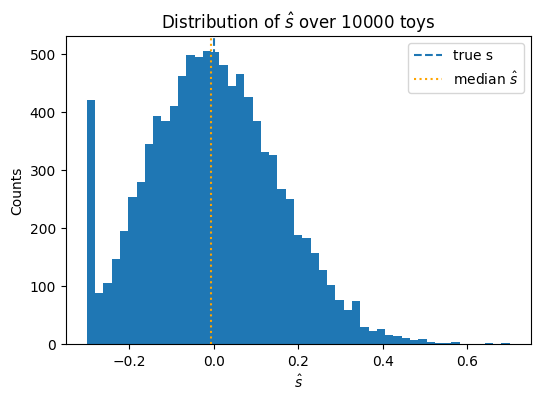

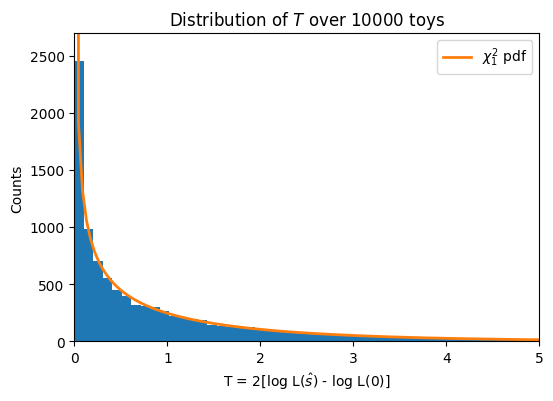

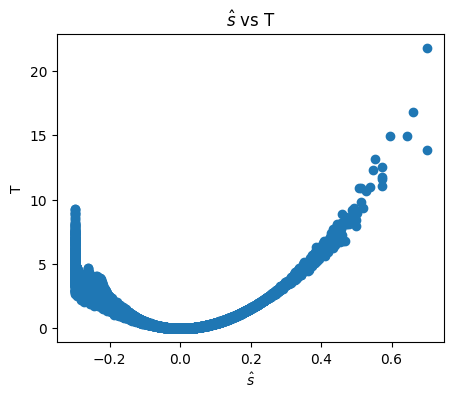

In [82]:
plots(s_hats, Ts)

In [83]:
s_hats, Ts, p_chi1s, p_chernoffs = statistical_analysis(data_sig)

s_hat: mean=0.3005, std=0.1693, median=0.3024144460899694
T:     mean=4.5114, std=4.0476, median=3.5068188168997096, q5=0.0990, q50=3.5068, q95=12.4556


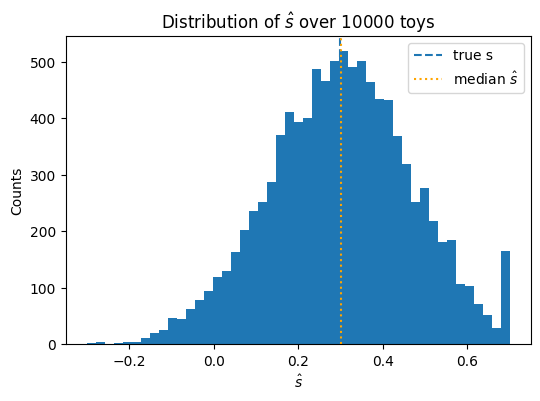

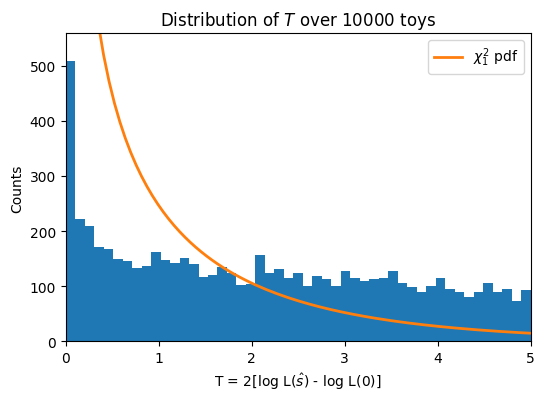

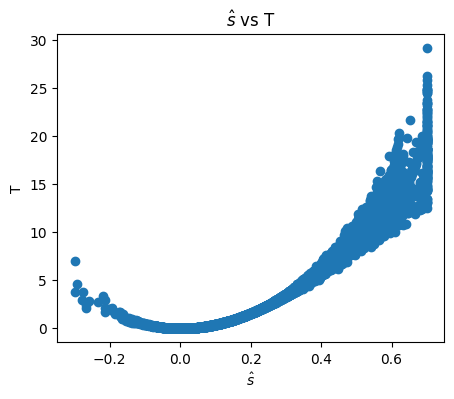

In [84]:
plots(s_hats, Ts, s_true=s_true)

### When the signal shape nor position is unknown
- LLR is out of applicability of Wilks' theorem
- Need toy MCs to determine the global significance
- $\lambda = -2\ln \frac{L(s=0 | \mu, \sigma)}{L(\hat{s}, \hat{\mu}, \hat{\sigma})}$, where $\mu$ and $\sigma$ are irrelevent in the numerator

In [85]:
s_hats, Ts, p_chi1s, p_chernoffs = statistical_analysis(data, mode='df3')

s_hat: mean=0.1667, std=0.4286, median=0.20568636351529584
T:     mean=4.1442, std=2.4832, median=3.734892025167518, q5=1.1250, q50=3.7349, q95=8.7542


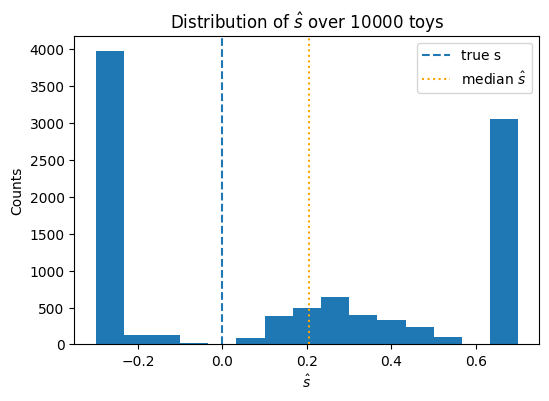

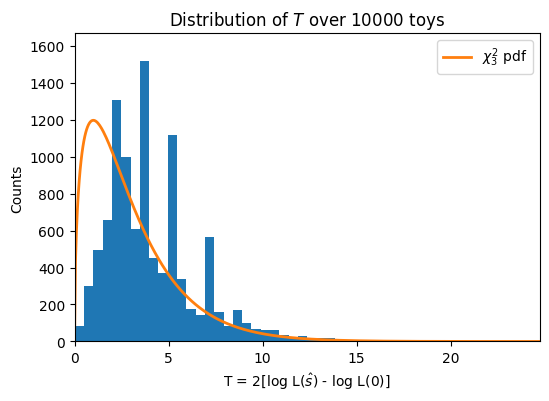

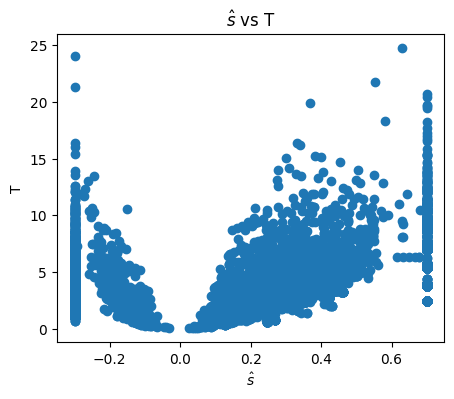

In [86]:
plots(s_hats, Ts, mode='df3')